In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

### Code copied from [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)
### Usage of [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [2]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

In [3]:
def visualize_data(data):
    points = data
    plt.scatter(points[:, 0], points[:, 1])
    plt.show()

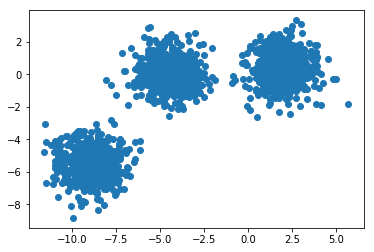

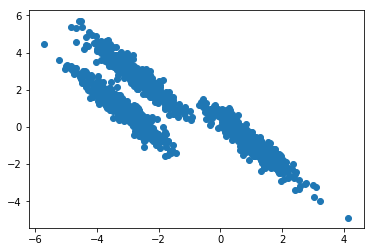

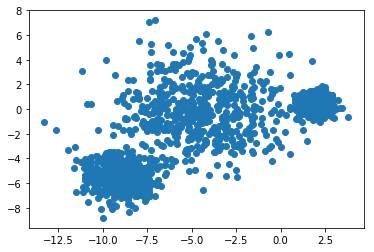

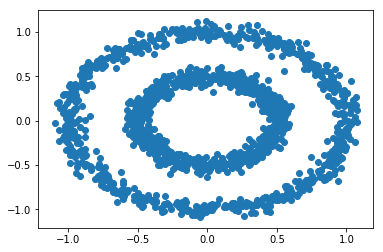

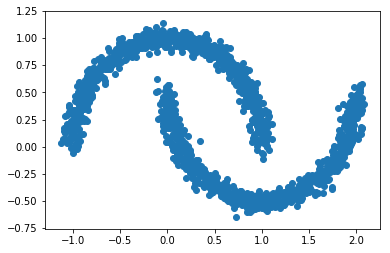

In [4]:
visualize_data(X)
visualize_data(X_aniso)
visualize_data(varied[0])
visualize_data(noisy_circles[0])
visualize_data(noisy_moons[0])

{'damping': 0.77, 'preference': -240, 'quantile': 0.2, 'n_clusters': 2, 'min_samples': 20, 'xi': 0.25}
{'damping': 0.75, 'preference': -220, 'n_clusters': 2}
{'eps': 0.18, 'n_neighbors': 2, 'min_samples': 5, 'xi': 0.035, 'min_cluster_size': 0.2}
{'eps': 0.15, 'n_neighbors': 2, 'min_samples': 20, 'xi': 0.1, 'min_cluster_size': 0.2}
{}
{}


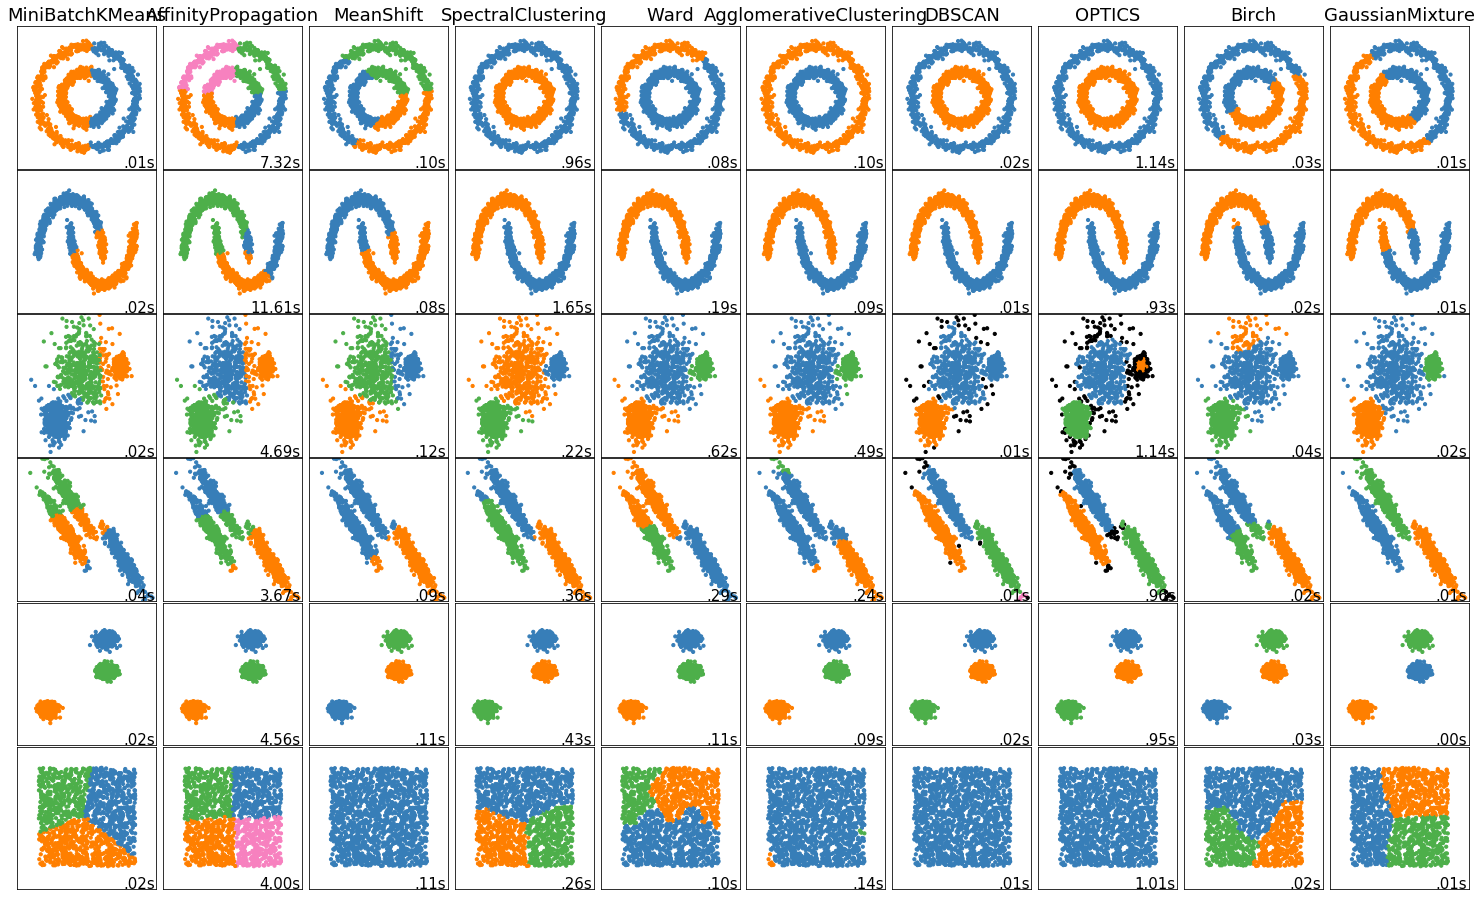

In [5]:
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)
    print(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'],
                            xi=params['xi'],
                            min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

### About Clustering Evaluation Metrics

- The silhouette value (1987) is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

- Calinski Harabasz score (1972) is defined as ratio between the within-cluster dispersion and the between-cluster dispersion. Dispersion is defined as the ratio of the variance σ to the mean μ, $$D = σ^2/μ$$

- Davies-Bouldin Index (1979)is the ratio between the within cluster distances and the between cluster distances and computing the average overall the clusters.

- Silhouette coefficient: higher better
- Calinski Harabasz score: higher better
- Davies-Bouldin Index: lower better


### Tests on the Moons Distribution

### Testing DBSCAN clustering algorithm

In [6]:
dataset = noisy_moons

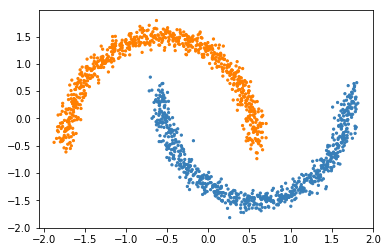

In [7]:
X, y = dataset
X = StandardScaler().fit_transform(X)
algorithm = cluster.DBSCAN(eps=0.2)
algorithm.fit(X)

if hasattr(algorithm, 'labels_'):
    y_pred = algorithm.labels_.astype(np.int)
else:
    y_pred = algorithm.predict(X)
    
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))    
plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred])
plt.show()

### How to evaluate a clustering result?

In [8]:
from sklearn import metrics

In [9]:
# Silhouette coefficient
print("Silhouette coefficient: " + str(metrics.silhouette_score(X, y_pred, metric='euclidean')))

# Calinski Harabasz score
print("Calinski Harabasz score: " + str(metrics.calinski_harabasz_score(X, y_pred)))

# Davies-Bouldin Index
print("Davies-Bouldin Index: " + str(metrics.davies_bouldin_score(X, y_pred)))

Silhouette coefficient: 0.3891199513969138
Calinski Harabasz score: 1299.6422322906212
Davies-Bouldin Index: 1.0230868386830778


### Testing Gaussian Mixture Model

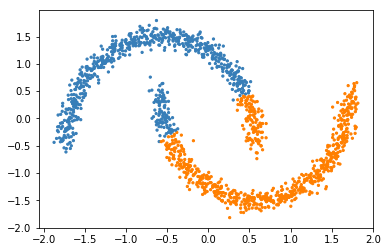

In [10]:
X, y = dataset
X = StandardScaler().fit_transform(X)
algorithm = mixture.GaussianMixture(n_components=2, covariance_type='full')
algorithm.fit(X)

if hasattr(algorithm, 'labels_'):
    y_pred = algorithm.labels_.astype(np.int)
else:
    y_pred = algorithm.predict(X)
    
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    
plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred])
plt.show()

In [11]:
# Silhouette coefficient
print("Silhouette coefficient: " + str(metrics.silhouette_score(X, y_pred, metric='euclidean')))

# Calinski Harabasz score
print("Calinski Harabasz score: " + str(metrics.calinski_harabasz_score(X, y_pred)))

# Davies-Bouldin Index
print("Davies-Bouldin Index: " + str(metrics.davies_bouldin_score(X, y_pred)))

Silhouette coefficient: 0.4997702888739452
Calinski Harabasz score: 2112.3603393797066
Davies-Bouldin Index: 0.8043258715065629


### Tests on Circles Distribution

### Testing DBSCAN clustering algorithm

In [12]:
dataset = noisy_circles

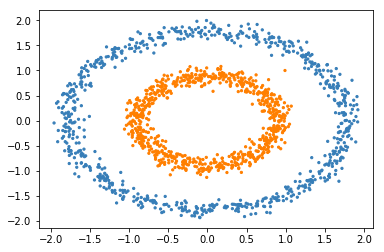

In [13]:
X, y = dataset
X = StandardScaler().fit_transform(X)
algorithm = cluster.DBSCAN(eps=0.2)
algorithm.fit(X)

if hasattr(algorithm, 'labels_'):
    y_pred = algorithm.labels_.astype(np.int)
else:
    y_pred = algorithm.predict(X)
    
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))    
plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred])
plt.show()

In [14]:
# Silhouette coefficient
print("Silhouette coefficient: " + str(metrics.silhouette_score(X, y_pred, metric='euclidean')))

# Calinski Harabasz score
print("Calinski Harabasz score: " + str(metrics.calinski_harabasz_score(X, y_pred)))

# Davies-Bouldin Index
print("Davies-Bouldin Index: " + str(metrics.davies_bouldin_score(X, y_pred)))

Silhouette coefficient: -0.09238304404180883
Calinski Harabasz score: 0.49406769136485307
Davies-Bouldin Index: 796.0550513514678


### Testing Gaussian Mixture Model

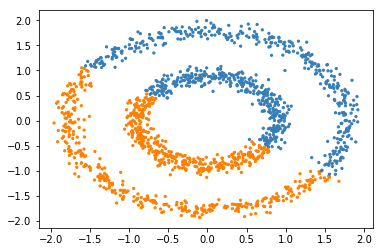

In [15]:
X, y = dataset
X = StandardScaler().fit_transform(X)
algorithm = mixture.GaussianMixture(n_components=2, covariance_type='full')
algorithm.fit(X)

if hasattr(algorithm, 'labels_'):
    y_pred = algorithm.labels_.astype(np.int)
else:
    y_pred = algorithm.predict(X)
    
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    
plt.scatter(X[:, 0], X[:, 1], s=5, color=colors[y_pred])
plt.show()

In [16]:
# Silhouette coefficient
print("Silhouette coefficient: " + str(metrics.silhouette_score(X, y_pred, metric='euclidean')))

# Calinski Harabasz score
print("Calinski Harabasz score: " + str(metrics.calinski_harabasz_score(X, y_pred)))

# Davies-Bouldin Index
print("Davies-Bouldin Index: " + str(metrics.davies_bouldin_score(X, y_pred)))

Silhouette coefficient: 0.353747337757006
Calinski Harabasz score: 861.8521713891636
Davies-Bouldin Index: 1.1848569544268097


### Conclusion

- Silhouette coefficient, Calinski Harabasz score, and Davies-Bouldin Index, in one way or another, quantify how close each node in a cluster is to each other node in the cluster, and how far removed they are from nodes in other clusters. It is easy to see how the more "intuitive" clustering produced by DBSCAN would perform worse. These 3 metrics look for the *closeness* of clusters, but what humans deem "intuitive" is more closely linked to *continuity* of the cluster.
- This explains why the scores for Moon distribution and circles distributions do not seem correct.
- These metrics favor convex based clustering algorithms, and do not favor density based clustering algorithms
- Now, if natural data is "convex" aka. blobby, then these 3 indices will perform fine. However, if real data looks closer to the Moons dataset, we may have a problem.
- My belief is there will be no issue. Jung.
- There exist alternate methods, as shown in this post [here](https://stats.stackexchange.com/questions/21807/evaluation-measures-of-goodness-or-validity-of-clustering-without-having-truth)

### What is 'cycle' and 'islice'

In [17]:
colors 

array(['#377eb8', '#ff7f00'], dtype='<U7')

In [18]:
for i in islice(cycle(['a', 'b', 'c']), 5):
    print(i)

a
b
c
a
b


In [19]:
colors[[1, 1, 0, 0]]

array(['#ff7f00', '#ff7f00', '#377eb8', '#377eb8'], dtype='<U7')